# Import-Export Analysis
To model the wheat price on the danish market, it might be valuable
to include features that give an indication of supply and demand. 
The assumption is, that the quantities of imported and exported wheat
can give such indications. 

The idea is to identify the countries with the largest import
of wheat from Denmark and then identify from what other countries they
import wheat. With data on wheat production in those countries, it
might be possible to model how much wheat will hit the market in the future. 

#### Underlying assumption:
- Countries import majority of wheat from a few exporters
- Those countries are mostly the same through the years


In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context("talk")

df = pd.read_csv("../../grain-price-data/wheat_import_export_EU.csv")
df.head()

,PERIOD,REPORTER,PARTNER,PRODUCT,FLOW,INDICATORS,Value,Flag and Footnotes
0,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),WORLD,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,34850860,NaN
1,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),WORLD,Wheat and meslin(1988-2500),EXPORT,QUANTITY_IN_100KG,10476666,NaN
2,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AD,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,:,NaN
3,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AD,Wheat and meslin(1988-2500),EXPORT,QUANTITY_IN_100KG,:,NaN
4,Jan.-Dec. 2000,BELGIUM (and LUXBG -> 1998),AE,Wheat and meslin(1988-2500),IMPORT,QUANTITY_IN_100KG,:,NaN


The dataset contains yearly data on all EU countries import and export of wheat from 2000 to 2020.
First we take a look at wheat export of 2019 from denmark:

In [136]:
# Select DK exports and drop rows without data
exports_DK = df.loc[(df['REPORTER'] == 'DENMARK') & ( df['FLOW'] == 'EXPORT')]
exports_DK = exports_DK.drop(exports_DK[(exports_DK.Value == ':') | (exports_DK.Value == '0')].index)

# get a list of the years that is easy to iterate through
periods = select_DK['PERIOD'].unique()

# get exports of 2019 and group them by import country
exports_DK_2019 = exports_DK.loc[export_DK['PERIOD'] == periods[-2]]
exports_DK_2019 = exports_DK_2019.groupby('PARTNER')['Value'].sum()
exports_DK_2019 = exports_DK_2019.astype(int).sort_values(ascending=False)[1:]
print(exports_DK_2019)


PARTNER
ES    3042527
SE     838205
NL     819636
FR     639093
LT     420075
IE     280094
DE     276666
PL     144652
FI     111009
IS     109237
GB      77294
NO      70137
BE      39426
LV       2216
AT        260
FO          7
CY          4
GL          4
Name: Value, dtype: int64


Spain is by far the largest importer of wheat from Denmark in 2019. The result includes the aggreate value for world, but Eurostat cautions that it is not computed when data is pulled, but stored in the database, so it might not be completely accurate.

Let's see how the importing countries are distributed in terms of the quantity:

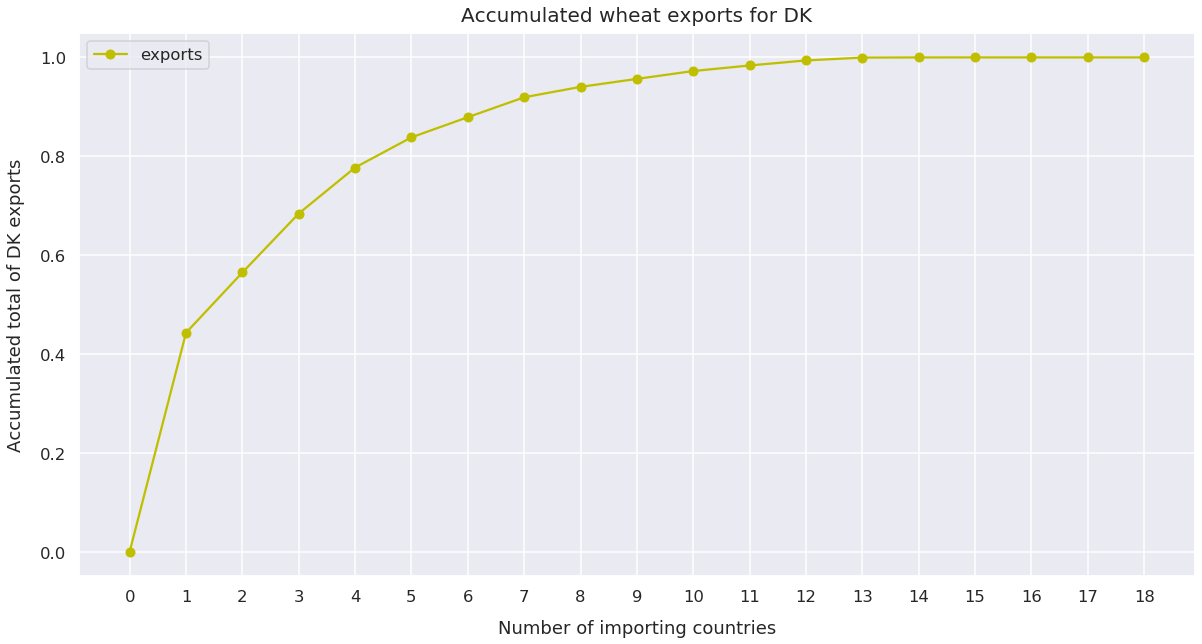

In [165]:
exports_cumulative = (exports_DK_2019.astype(int).cumsum() / exports_DK_2019.astype(int).sum()).values
exports_cumulative = np.insert(exports_cumulative, 0 ,0)


plt.title("Accumulated wheat exports for DK", y=1.01, fontsize=20)
plt.ylabel("Accumulated total of DK exports", labelpad=15)
plt.xlabel("Number of importing countries", labelpad=15)
plt.rcParams['figure.figsize'] = [20,10]
plt.xticks(range(len(exports_cumulative)))
plt.plot(exports_cumulative,'yo-', label='exports')
plt.legend()
plt.show()


For 2019 it appears that five importing countries account for more than 80% of the total wheat
exports from DK.